## Курсовой проект по курсу **«Библиотеки Python для Data Science: продолжение»**

##### 

**Ник на Kaggle: tyashin**

### Задание: подготовить модель предсказания класса объектов и принять участие в соревновании на Kaggle (https://www.kaggle.com/c/gb-credit-default/)

**Целевые значения метрик:**
* F1-score > 0.5 на private Leaderboard
* F1-score_1, recall_1, precision_1 > 0.5

#### 

### 1. Импорт всех необходимых библиотек и установка глобальных параметров

In [1]:
# 1. Основные библиотеки
import random
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

# 3. Модели
from catboost import CatBoost, CatBoostClassifier, cv, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

# 4. Метрики качества
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

# 5. Стандартизация
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})  # размер шрифта на графиках
sns.set(rc={"figure.figsize":(12, 6)})
sns.set(font_scale = 1.3)
random.seed(1)

In [3]:
#Пути к директориям и файлам
TRAINING_DATASET_PATH = 'train.csv'
VALIDATION_DATASET_PATH = 'test.csv'
PREDICTION_PATH = 'submission.csv'
PREPARED_DATASET_PATH_TRAIN = 'credit_prepared_train.csv'
PREPARED_DATASET_PATH_TEST = 'credit_prepared_test.csv'
SAMPLE_SUBMISSION_PATH = 'sample_submission.csv'

#### 

### 2. Загрузка данных

**Описание датасета:**

- **Home Ownership** - домовладение
- **Annual Income** - годовой доход
- **Years in current job** - количество лет на текущем месте работы
- **Tax Liens** - налоговые обременения
- **Number of Open Accounts** - количество открытых счетов
- **Years of Credit History** - количество лет кредитной истории
- **Maximum Open Credit** - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
- **Number of Credit Problems** - количество проблем с кредитом
- **Months since last delinquent** - количество месяцев с последней просрочки платежа
- **Bankruptcies** - банкротства
- **Purpose** - цель кредита
- **Term** - срок кредита
- **Current Loan Amount** - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
- **Current Credit Balance** - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
- **Monthly Debt** - ежемесячный долг
- **Credit Score** - баллы кредитного рейтинга
- **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [4]:
original_train_df = pd.read_csv(TRAINING_DATASET_PATH)
validation_df = pd.read_csv(VALIDATION_DATASET_PATH)

In [5]:
original_train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
original_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
validation_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### 

**Уменьшение объема памяти, которую занимают датасеты**

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
original_train_df = reduce_mem_usage(original_train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [11]:
original_train_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

In [12]:
validation_df = reduce_mem_usage(validation_df)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


In [13]:
validation_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
dtype: object

#### 

**Выделение признакового описания и целевой переменной**

In [14]:
TARGET_NAME = 'Credit Default'
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

#### 

### 3. EDA

**Распределение целевой переменной**

Text(0.5, 1.0, 'Распределение целевой переменной')

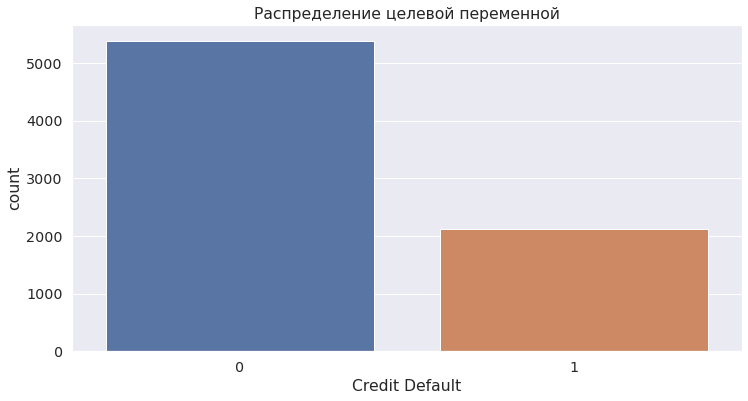

In [15]:
sns.countplot(x=original_train_df['Credit Default'])
plt.title('Распределение целевой переменной')

#### 

**Обзор количественных признаков**

In [16]:
original_train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


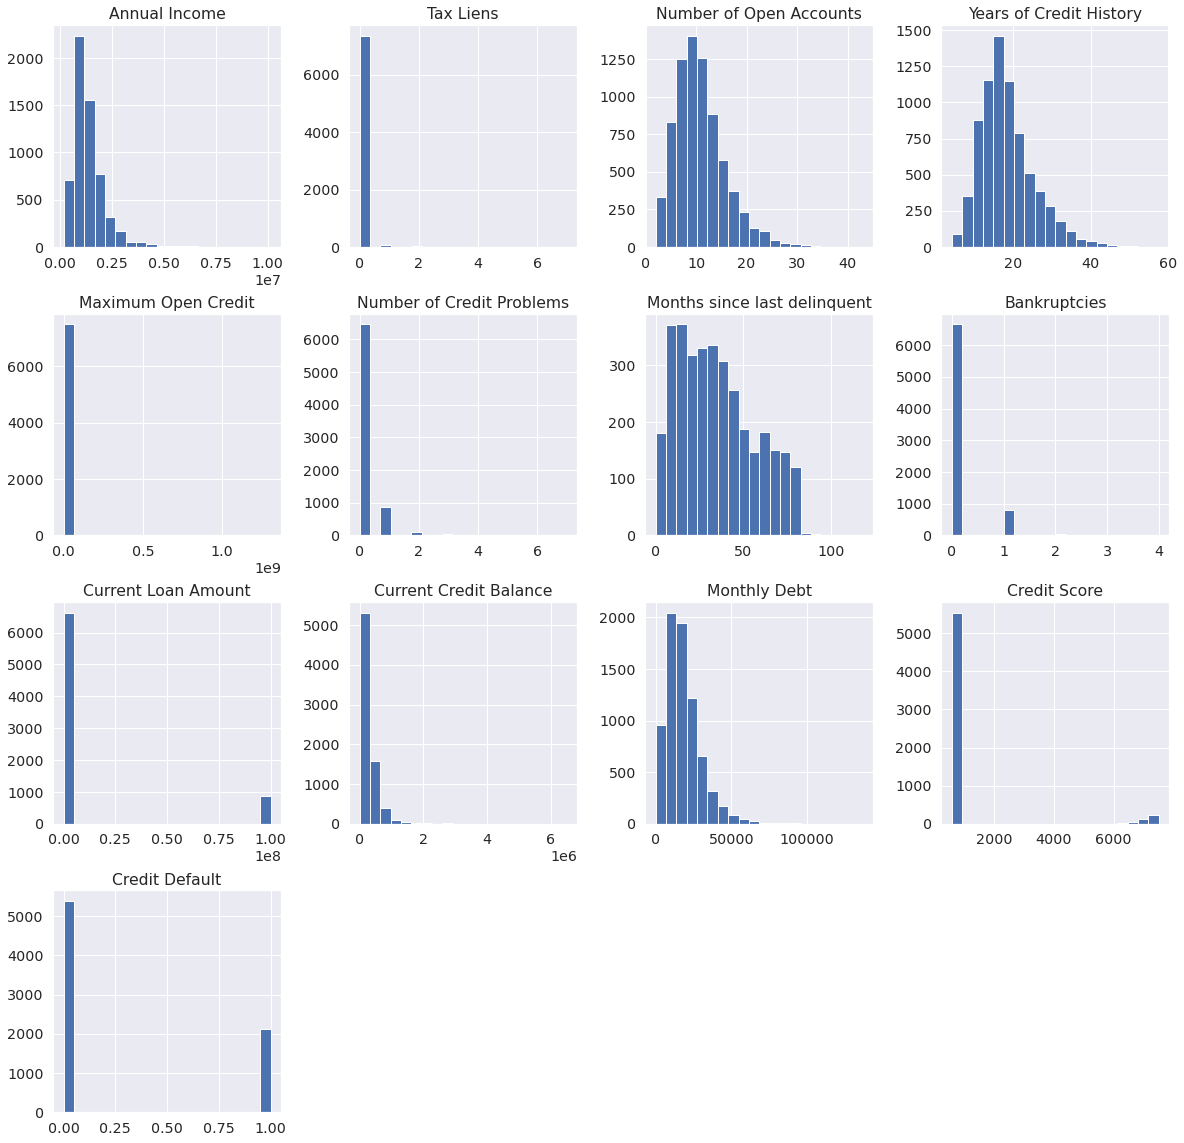

In [17]:
original_train_df.hist(bins = 20, figsize = (20, 20))
plt.show()

#### 

**Обзор категориальных признаков**

In [18]:
for col in original_train_df.select_dtypes(include='category').columns:
    print(str(col) + '\n\n' + str(original_train_df[col].value_counts()) + '\n' + '*' * 40 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
****************************************

Te

**Корреляция признаков**

[Text(0.5, 1.0, 'Корреляция признаков')]

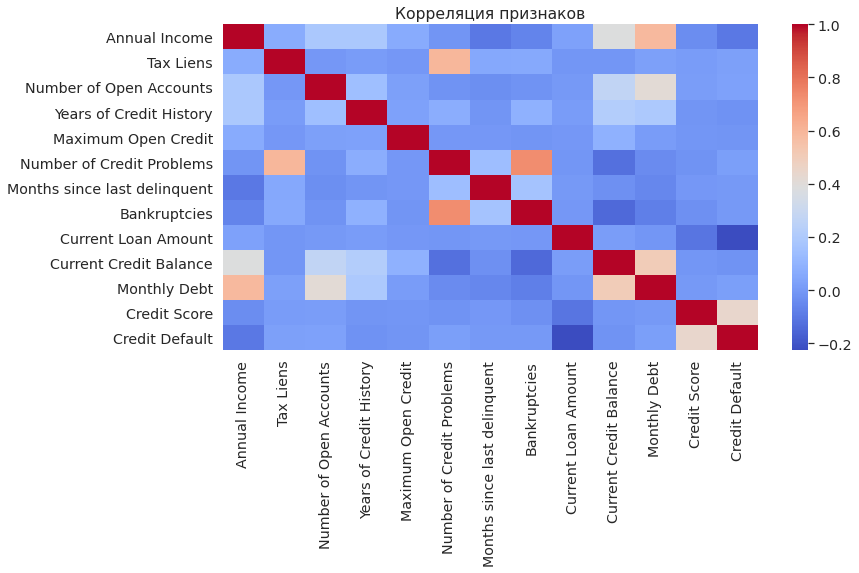

In [19]:
df = original_train_df.select_dtypes(include=['int8', 'float32'])
sns.heatmap(df.corr(), cmap='coolwarm').set(title='Корреляция признаков')

#### 

### 4. Предобработка данныхи генерация новых признаков

In [20]:
class DataPreprocessor:
    def __init__(self):
        self.medians=None
        self.modes = None
        self.max_score = 850
        self.max_credit = 99999999.0
        
    def fit(self, X):
        """Сохранение статистик""" 
        # Расчет медиан и мод
        self.medians = X.median()
        self.modes = X.mode().loc[0]
                
    def transform(self, X):
        """Трансформация данных"""
        
        # Annual Income
        X['Annual Income NaN'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income NaN'] = 1
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace = True)     

        # Credit score
        X['Credit Score Outlier'] = 0
        X['Credit Score NaN'] = 0
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score Outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score NaN'] = 1
        X.loc[X['Credit Score'] > self.max_score, 'Credit Score'] = self.max_score
        
        # Current Loan Amount
        X['Current Loan Amount Outlier'] = 0
        X['Current Loan Amount NaN'] = 0
        X.loc[X['Current Loan Amount'] > self.max_credit, 'Current Loan Amount Outlier'] = 1
        X.loc[X['Current Loan Amount'].isna(), 'Current Loan Amount Nan'] = 1
        X.loc[X['Current Loan Amount'] > self.max_credit, 'Current Loan Amount'] = self.max_credit
        
        # Maximum Open Credit
        X['Maximum Open Credit Outlier'] = 0
        X['Maximum Open Credit NaN'] = 0
        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit Outlier'] = 1
        X.loc[X['Maximum Open Credit'].isna(), 'Maximum Open Credit NaN'] = 1
        X.loc[X['Maximum Open Credit'] > self.max_credit, 'Maximum Open Credit'] = self.max_credit
                      
        # Years in current job
        X['Years in current job NaN'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job NaN'] = 1
        X['Years in current job'].fillna(self.modes['Years in current job'], inplace = True)
        
        # Months since last delinquent
        X.drop('Months since last delinquent', axis=1, inplace=True)
        
        # Bankruptcies
        X['Bankruptcies NaN'] = 0
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies NaN'] = 1
        X['Bankruptcies'].fillna(0, inplace = True)
        
        X.fillna(self.medians, inplace=True)
        
        return X
        

In [21]:
preprocessor = DataPreprocessor()
preprocessor.fit(original_train_df)
original_train_df = preprocessor.transform(original_train_df)
validation_df = preprocessor.transform(validation_df)
original_train_df.shape, validation_df.shape

((7500, 26), (2500, 25))

In [22]:
class FeatureGenetator():
    """Генерация новых фич"""
    
                  
    def transform(self, X):
        
        # Term
        X['Long Term'] = X['Term'].map({'Long Term': 1, 'Short Term': 0})
        CAT_FEATURE_NAMES.append('Long Term')
                     
        # Credit Score
        X = self.credit_score_to_cat(X)
        
        # Years in current job
        X['Years in current job SHORT'] = X['Years in current job'].map({'< 1 year':'novice', 
                                                                       '1 year':'novice', 
                                                                       '2 years':'sophomore', 
                                                                       '3 years':'senior', 
                                                                       '4 years':'senior', 
                                                                       '5 years':'senior', 
                                                                       '6 years':'senior', 
                                                                       '7 years':'senior',
                                                                       '8 years':'senior',
                                                                       '9 years':'senior',
                                                                       '10+ years':'oldtimer'})
        CAT_FEATURE_NAMES.append('Years in current job SHORT')
        
        return X
    
    def credit_score_to_cat(self, X):
        bins = [300, 579, 669, 739, 799, 850]
        X['Credit Score Cat'] = pd.cut(X['Credit Score'], bins=bins, labels=False)
        X['Credit Score Cat NaN'] = 0
        X.loc[X['Credit Score Cat'].isna(), 'Credit Score Cat NaN'] = 1
        X['Credit Score Cat'].fillna(0, inplace=True)
        CAT_FEATURE_NAMES.append('Credit Score Cat')
        
        return X

In [23]:
features_gen = FeatureGenetator()
original_train_df = features_gen.transform(original_train_df)
validation_df = features_gen.transform(validation_df)
original_train_df.shape, validation_df.shape

((7500, 30), (2500, 29))

#### 

### 5. Разделение датасета на train и test

In [24]:
X = original_train_df.drop(columns=TARGET_NAME)
y = original_train_df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5250, 29), (2250, 29), (5250,), (2250,))

In [25]:
X_train.to_csv(PREPARED_DATASET_PATH_TRAIN, index=False, encoding='utf-8', sep=';')
X_test.to_csv(PREPARED_DATASET_PATH_TEST, index=False, encoding='utf-8', sep=';')

#### 

### 6. Построение моделей

In [26]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [27]:
def evaluate_preds(model, X_train, X_valid, y_train, y_valid):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

In [28]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.6082474226804124

In [29]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':42,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [30]:
gb_model = CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
gb_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(gb_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      3795
           1       0.52      0.62      0.56      1455

    accuracy                           0.73      5250
   macro avg       0.68      0.70      0.69      5250
weighted avg       0.75      0.73      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1592
           1       0.52      0.59      0.55       658

    accuracy                           0.72      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1225  367
1                268  390


### 6. Оценка полезности признаков

In [31]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
11,Current Loan Amount,39.137410
26,Credit Score Cat,21.633117
14,Credit Score,9.875576
16,Credit Score Outlier,8.205320
1,Annual Income,3.626812
10,Term,3.413379
25,Long Term,2.402201
6,Maximum Open Credit,1.906269
17,Credit Score NaN,1.625691
23,Years in current job NaN,1.540741


#### 

### 7. Подготовка файла для Kaggle

In [32]:
predictions = gb_model.predict(validation_df)
predictions.shape

(2500,)

In [33]:
submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
submission.shape

(2500, 2)

In [34]:
submission['Credit Default'] = predictions
submission.head()

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


In [35]:
submission.to_csv('my_submission.csv', index=False)